# Basic Hands-On 2: Neural networks for regression - simple energy reconstruction with TA

In this example, we want to do a reconstruction for a detector such as TA surface array.  As we just saw in the previous examples, we want to estimate a quantity in reality from many different features. Here, the two features are total signal and arrival times, which are located in two different files. The TA reconstruction framework exploits the spatial information of each event by defining a 7x7 tile out of the surface array. We will learn how to visualize the input data and how to move from a fully connected simple network to a convolutional network.


### 1. Load data from ascii file and visualize

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim

# Set device (GPU if available, mps on Mac, else CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")


Read data from files. Note that first 5 columns are identical. These are the columns: 
* 0: id  
* 1: energy  
* 2,3,4: shower axis (nx, ny, nz)  
* 5-54: total signal and arrival times. For each event (row), 7x7=49 values. The shape is restored using the `reshape` method.


In [2]:
data_total_signal = np.loadtxt("total_signal_prot.txt", comments="#", dtype=np.float32)
data_arrival_times = np.loadtxt("arrival_times_prot.txt", comments="#", dtype=np.float32)

data = dict()
data["energy"] = data_total_signal[:, 1]
data["shower_axis"] = data_total_signal[:, 2:5]
data["total_signal"] = data_total_signal[:, 5:].reshape(-1, 7, 7)
data["arrival_times"] = data_arrival_times[:, 5:].reshape(-1, 7, 7)

### 2. Investigate numerical data of event with `evt_id`

_Note_: Change evt_id to visualize another event

Each event has a dimension of 7x7-tile within the TA SD array.


In [3]:
evt_id = 59
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nArrival times")
print(data["arrival_times"][evt_id])
print("\nTotal signal")
print(data["total_signal"][evt_id])

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Arrival times
[[    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.  29439.6 31178.4     0.      0. ]
 [    0.      0.      0.  29119.8 31008.5     0.      0. ]
 [    0.      0.      0.  30448.9     0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]]

Total signal
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     59.4497 64.2563  0.      0.    ]
 [ 0.      0.      0.     76.1689 37.1075  0.      0.    ]
 [ 0.      0.      0.     20.2708  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]]


Numbers show which detectors saw a signal. The remaining detectors in the array show values of 0. Visualizing the data before feeding it into a network is crucial. In case of missing entries in the files, we need to assign a 0 or nan/infinity value (depending on your problem). DNNs cannot deal with missing data.

Before we will train a network, let's take a closer look at the data:

### 3. Visualize event: heatmaps of arrival times and total signal

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Arrival times
[[    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.  29439.6 31178.4     0.      0. ]
 [    0.      0.      0.  29119.8 31008.5     0.      0. ]
 [    0.      0.      0.  30448.9     0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]
 [    0.      0.      0.      0.      0.      0.      0. ]]

Total signal
[[ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.     59.4497 64.2563  0.      0.    ]
 [ 0.      0.      0.     76.1689 37.1075  0.      0.    ]
 [ 0.      0.      0.     20.2708  0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.    ]]


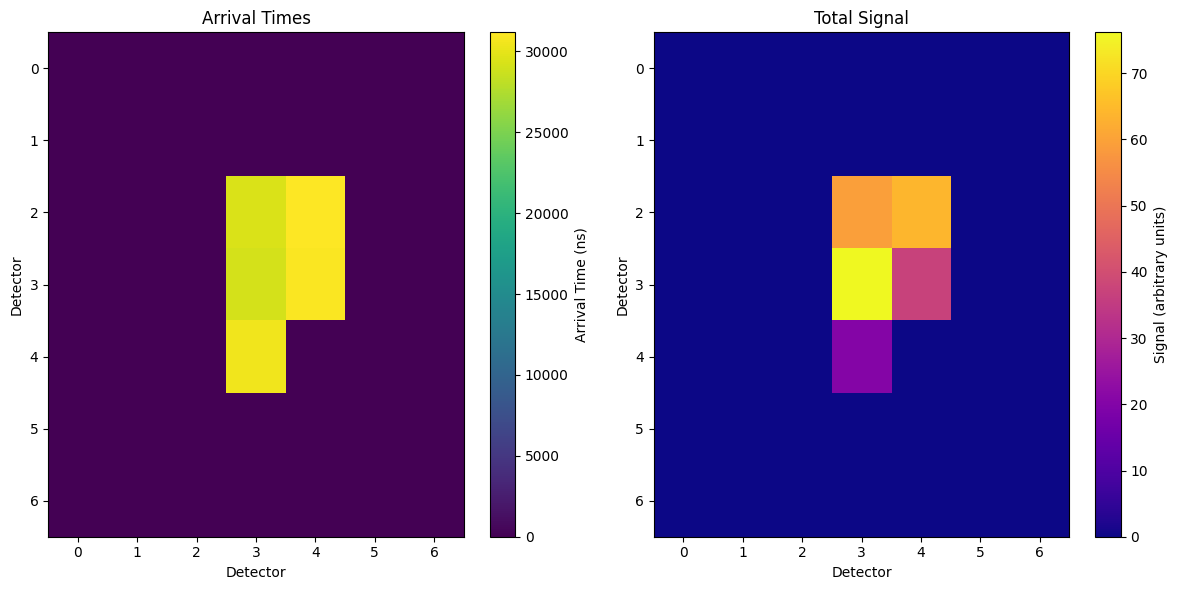

In [4]:
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nArrival times")
arrival_times = data["arrival_times"][evt_id]
print(arrival_times)
print("\nTotal signal")
total_signal = data["total_signal"][evt_id]
print(total_signal)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for Arrival Times
c1 = axs[0].imshow(arrival_times, aspect="auto", cmap="viridis")
axs[0].set_title("Arrival Times")
axs[0].set_xlabel("Detector")
axs[0].set_ylabel("Detector")
plt.colorbar(c1, ax=axs[0], label="Arrival Time (ns)")

# Heatmap for Total Signal
c2 = axs[1].imshow(total_signal, aspect="auto", cmap="plasma")
axs[1].set_title("Total Signal")
axs[1].set_xlabel("Detector")
axs[1].set_ylabel("Detector")
plt.colorbar(c2, ax=axs[1], label="Signal (arbitrary units)")

plt.tight_layout()
plt.show()

#### Normalize data and visualize **normalized** arrival times and total signal

Networks often perform better when the input data is defined within a specific range, meaning that all parameters are within the same range. This is often realized by rescaling or normalizing the data.

Event id=59

Energy=3.05649995803833 EeV

Shower axis=[ 0.0875133 -0.448413   0.889532 ]

Normalized Arrival Times
[[0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       3.0439599 3.21784   0.1       0.1      ]
 [0.1       0.1       0.1       3.01198   3.20085   0.1       0.1      ]
 [0.1       0.1       0.1       3.14489   0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]
 [0.1       0.1       0.1       0.1       0.1       0.1       0.1      ]]

Normalized Total Signal
[[0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.4102 0.4177 0.     0.    ]
 [0.     0.     0.     0.4346 0.364  0.     0.    ]
 [0.     0.     0.     0.3057 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.    

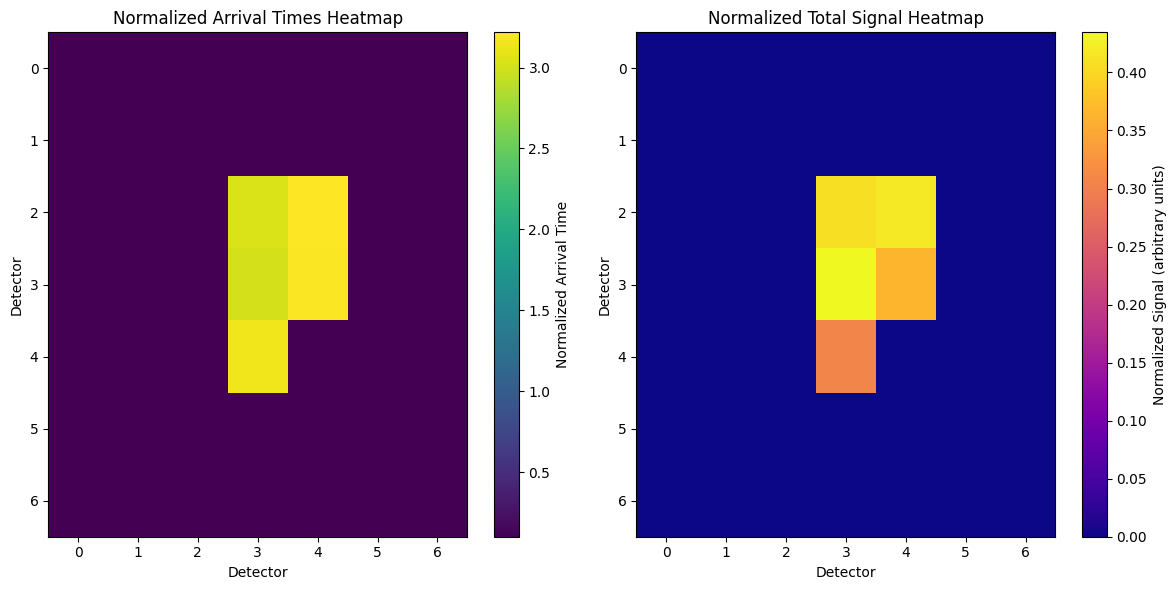

In [5]:
# Normalization and scaling for Arrival Times
min_arrv_times = arrival_times.min()  # Get the minimum arrival time for scaling
shift = 1000  # nanoseconds
scale = 10000  # nanoseconds
arrival_times_scaled = (arrival_times - min_arrv_times + shift) / scale

# Normalization for Total Signal
total_signal_scaled = np.log1p(total_signal) / 10
total_signal_scaled = total_signal_scaled.astype(np.float16)

# Printing outputs
print(f"Event id={evt_id}")
print(f"\nEnergy={data['energy'][evt_id]} EeV")
print(f"\nShower axis={data['shower_axis'][evt_id]}")
print("\nNormalized Arrival Times")
print(arrival_times_scaled)
print("\nNormalized Total Signal")
print(total_signal_scaled)

# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for Normalized Arrival Times
c1 = axs[0].imshow(arrival_times_scaled, aspect="auto", cmap="viridis")
axs[0].set_title("Normalized Arrival Times Heatmap")
axs[0].set_xlabel("Detector")
axs[0].set_ylabel("Detector")
plt.colorbar(c1, ax=axs[0], label="Normalized Arrival Time")

# Heatmap for Normalized Total Signal
c2 = axs[1].imshow(total_signal_scaled, aspect="auto", cmap="plasma")
axs[1].set_title("Normalized Total Signal Heatmap")
axs[1].set_xlabel("Detector")
axs[1].set_ylabel("Detector")
plt.colorbar(c2, ax=axs[1], label="Normalized Signal (arbitrary units)")

plt.tight_layout()
plt.show()

Note: matplotlib has many different colormaps. Choose the most suitable color maps according to your problem. The same data might appear differently in different colormaps.

### 4. Separate data into test and training set

We need to separate the data into a training set and a test set and reshape the data to be used in the network framework. The network cannot handle the 7x7-shaped inputs from two different files (arrays). When you feed data into the neural network model, the 7x7 grid of arrival times and total signals (which is a 2D array) needs to be converted into a 1D array with 49 elements (since 7 × 7 = 49), as we did in the exercises in Basic I. For example, if you have a batch of inputs with the shape (batch_size, 7, 7) (where batch_size is the number of data samples in the batch), you need to "flatten" each 7x7 grid into a 1D vector of length 49 so that the input shape becomes (batch_size, 49).


In [6]:
total_signal_scaled.shape

(7, 7)

In [7]:
data["arrival_times"].shape

(51653, 7, 7)

In [8]:
data["total_signal"].shape

(51653, 7, 7)

In [9]:
total_signal = torch.tensor(data["total_signal"], dtype=torch.float32).to(device)
arrival_time = torch.tensor(data["arrival_times"], dtype=torch.float32).to(device)
energy = torch.tensor(data["energy"], dtype=torch.float32).to(device)


In [10]:
# Flatten the arrays to shape (51653, 49)
total_signal_flat = total_signal.view(total_signal.size(0), -1)  # Shape: (51653, 49)
arrival_time_flat = arrival_time.view(arrival_time.size(0), -1)  # Shape: (51653, 49)

In [11]:
arrival_time_flat.shape

torch.Size([51653, 49])

In [12]:
# Combine flattened arrays if needed (e.g., by concatenation)
# Here we can concatenate both arrays if you want to input both features
combined_features = torch.cat((total_signal_flat, arrival_time_flat), dim=1)  # Shape: (51653, 98)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(combined_features, energy, test_size=0.2, random_state=42)

# Print shapes to verify
print(f'Train feature shape: {X_train.shape}')  # Should be (41322, 98)
print(f'Test feature shape: {X_test.shape}')    # Should be (10331, 98)
print(f'Train target shape: {y_train.shape}')    # Should be (41322, 1)
print(f'Test target shape: {y_test.shape}')      # Should be (10331, 1)


Train feature shape: torch.Size([41322, 98])
Test feature shape: torch.Size([10331, 98])
Train target shape: torch.Size([41322])
Test target shape: torch.Size([10331])


The data set is very large and we can run out of memory quickly. Therefore, training is often done by iterating over smaller batches of the input data.

In [14]:
from torch.utils.data import Dataset, DataLoader

class CosmicRayDataset(Dataset):
    def __init__(self, X_data, y_data):
        # Store the input features (X_data) and target values (y_data)
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.X_data)

    def __getitem__(self, index):
        # Retrieve a single sample at the given index
        X_sample = self.X_data[index]
        y_sample = self.y_data[index]
        # return torch.tensor(X_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)
        return X_sample, y_sample

# Assuming X_train and y_train are NumPy arrays with shape (N, 7, 7) and (N, 1)
dataset = CosmicRayDataset(X_train, y_train)

In [15]:
batch_size = 64
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [16]:
# illustration of batch training and shapes

for x_batch, y_batch in train_loader:
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([64, 98]) torch.Size([64])


### 5.  Train and evalulate the model

We are familiar with this step from the previous exercise and will simply take the same model for regression. We can import the class and function, but for better clarity, we will just copy it from the previous day Basic I.

In [17]:
class CosmicRayNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(CosmicRayNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Output layer (no activation)
        return x.squeeze(1)  # Squeeze the output to match the target shape

In [18]:
input_size = 98
hidden_size1 = 64
hidden_size2 = 32
model = CosmicRayNN(input_size, hidden_size1,hidden_size2).to(device) # put model to device, as we always did before

In [19]:
# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training function
def train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=100):

    dataset = CosmicRayDataset(X_train, y_train)
    batch_size = 128
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    losses = []
    for epoch in range(epochs):
        for x_batch, y_batch in train_loader: # loop over every batch
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
        # Record the loss
        losses.append(loss.item())
            
        # Print loss for every 10th epoch
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
    return losses


In [20]:
def loss_function_plot(epochs,losses):
    plt.plot(range(epochs), losses)
    plt.title("Loss Curve during Training")
    plt.xlabel("Epochs")
    #plt.yscale('log')
    plt.ylabel("Mean Squared Error Loss")
    plt.show()

Epoch [10/100], Loss: 1811.9497
Epoch [20/100], Loss: 4217.9468
Epoch [30/100], Loss: 1145.7010
Epoch [40/100], Loss: 2269.7961
Epoch [50/100], Loss: 3514.7024
Epoch [60/100], Loss: 1501.3926
Epoch [70/100], Loss: 2864.2241
Epoch [80/100], Loss: 1810.0636
Epoch [90/100], Loss: 644.1061
Epoch [100/100], Loss: 1981.5065


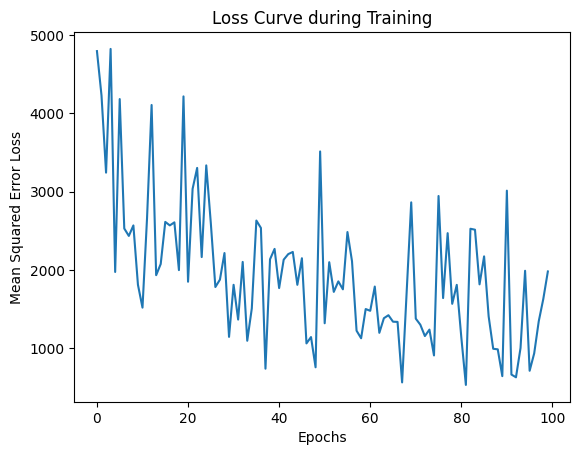

In [21]:
# Train the model and plot the loss curve
epochs = 100
losses = train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs=epochs)

# Plot the loss curve
loss_function_plot(epochs,losses)

The loss decreases with the number of epochs.

As a final step, we will evaluate the model on a new unseen set of data: the test set.




Test Loss: 2638.8633


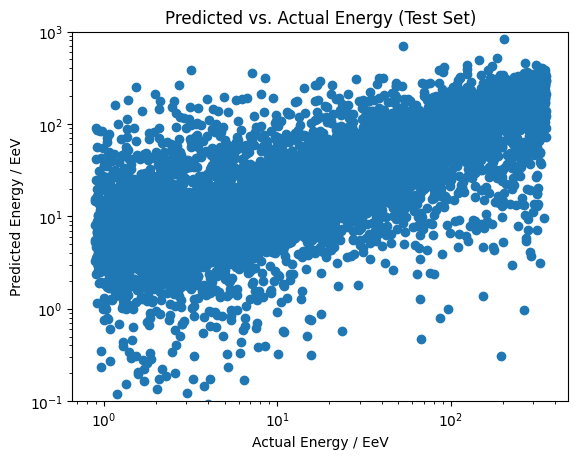

In [22]:
# Evaluation function
def evaluate_cosmic_ray_model(model, X_test, y_test, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return outputs

# Evaluate the model on the test set
test_outputs = evaluate_cosmic_ray_model(model.to(device), X_test.to(device), y_test.to(device), criterion)

# Optional: plot the predicted vs. actual energy values

plt.scatter(y_test.cpu(), test_outputs.cpu())
plt.xlabel('Actual Energy / EeV')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1, 1e3)
plt.ylabel('Predicted Energy / EeV')
plt.title('Predicted vs. Actual Energy (Test Set)')
plt.show()

The prediction of the model is still somewhat random, but a linear trend is observable. A good reconstruction should show a linear relationship between the prediction and the actual value.
In the following task, we will switch from a fully connected network to a convolutional network to see whether the predictions can be improved.

## Exercise: from fully connected to convolutional network


To change from the simple DNN to convolutional layers using `nn.Conv2d`, we aim to capture local spatial features from the input data. We start with 2 input channels (total signal and arrival time).
After applying the convolutions, the output is flattened to feed into the fully connected layers. After the convolutional layers, the model uses two fully connected layers for the final regression. This is what we already learned today.

Create this network, train it and evalulate its performance.


In [24]:
class CosmicRayCNN(nn.Module):
    def __init__(self):
        super(CosmicRayCNN, self).__init__()
        
        # Define a 2D convolutional layer
        self.conv1 = nn.Conv2d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layers after convolution
        self.fc1 = nn.Linear(32 * 7 * 7, 64)  # 32 channels, 7x7 image after conv layers
        self.fc2 = nn.Linear(64, 1)  # Output layer for regression (1 target: energy)

    def forward(self, x):
        # Convolutional layers with ReLU activations
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        
        # Flatten the output from conv layers to feed into fully connected layers
        x = x.view(x.size(0), -1)  # Reshape to (batch_size, 32*7*7)
        
        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer (no activation for regression)
        
        return x.squeeze()

Before we continue, we take a closer look at possible settings of the **convolutional layer**:

* `in_channels=2`:
<br> The number of input channels to the layer. This corresponds to the two different feature maps: total signal and arrival time. Each channel can be seen as a separate "layer" of the input data.
We use a 7x7 grid, so the input has the shape (batch_size, 2, 7, 7). This means  2 channels, and each channel with a 7x7 grid.

* `out_channels=16`:
<br> The number of output channels (also called feature maps) produced by this convolutional layer is 16. This means that after the convolution, the layer will produce 16 different 7x7 grids, each representing different features or patterns that the network has learned from the input. Each output channel will result from a separate convolution filter applied over the input channels.

* `kernel_size=3`:
<br> This defines the size of the convolutional filter. In this case, a 3x3 filter (kernel) is used.
The filter will slide over the 7x7 grid, looking at a 3x3 window of values at a time to detect local patterns (like edges or specific spatial relationships).

* `stride=1`:
<br> Stride defines how much the filter moves as it slides across the input. A stride of 1 means the filter will move 1 pixel at a time horizontally and vertically.
A stride of 1 ensures that the output grid remains the same size as the input grid (7x7), assuming appropriate padding.

* `padding=1`:
<br> Padding adds a border of zeros around the input data to control the output size. Padding of 1 adds a 1-pixel border around the 7x7 grid, effectively enlarging the grid to 9x9 before applying the convolution. The padding ensures that after applying the 3x3 kernel with stride 1, the output grid remains 7x7, rather than shrinking (without padding, a 3x3 kernel on a 7x7 input would shrink it to 5x5).

**Number of Parameters**:

For conv1, there are 2×16×3×3 weights (plus biases), as each of the 16 filters needs a 3x3 weight matrix for each of the 2 input channels. 

For conv2, there are 16×32×3×3 weights, as each of the 32 filters needs a 3x3 weight matrix for each of the 16 input channels.

After the convolution, an activation function like ReLU (Rectified Linear Unit) is usually applied to introduce non-linearity. This helps the network capture more complex patterns.


In [25]:
# Initialize the model
model = CosmicRayCNN().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Reshape X_train and X_test back to 4D tensors
X_train = X_train.view(-1, 2, 7, 7)  # Batch size automatically inferred
X_test = X_test.view(-1, 2, 7, 7)    # Same for test set


The challenge in DNNs is the correct **shaping of the input data**:

We need to reshape the tensor back to 4D to feed the data into a convolutional network. Convolutional layers in a CNN work with multidimensional data that has a specific structure. The expected input format for a 2D convolutional layer (`nn.Conv2d`) is a 4D tensor with the shape: `(batch_size, channels, height, width)`:

* `batch_size`: The number of samples being processed together in one forward pass. In PyTorch, this is handled dynamically with -1 when reshaping, and the actual size depends on the data and the batch size in training.

* `channels`: The number of feature maps (or channels) in the input. For typical images, channels correspond to color channels (e.g., RGB images have 3 channels), but in your case, channels represent different physical measurements—total signal and arrival time—so you have 2 channels.

* `height and width`: The spatial dimensions of the input data. In your case, these are the dimensions of the 7x7 grid at each detector

### Training the model

Epoch [10/100], Loss: 3186.0950
Epoch [20/100], Loss: 1738.4983
Epoch [30/100], Loss: 1722.0012
Epoch [40/100], Loss: 2401.6379
Epoch [50/100], Loss: 1033.0562
Epoch [60/100], Loss: 1223.1017
Epoch [70/100], Loss: 648.1816
Epoch [80/100], Loss: 858.9491
Epoch [90/100], Loss: 525.6631
Epoch [100/100], Loss: 770.4567


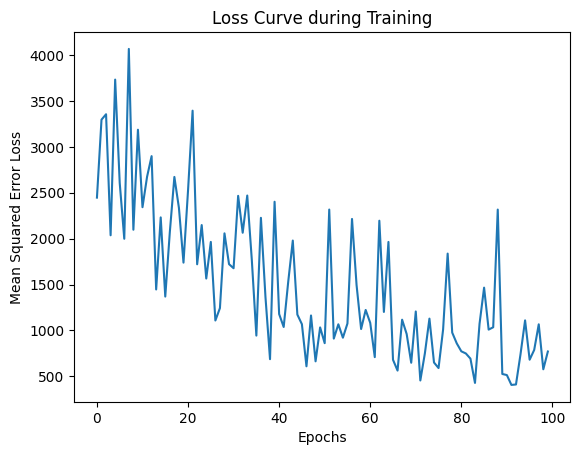

In [26]:
# Train the CNN model
epochs = 100
losses = train_cosmic_ray_model(model, X_train, y_train, criterion, optimizer, epochs)

# Plot the loss curve
loss_function_plot(epochs, losses)

## Extra exercise

Improving the convolutional neural network for better performance can be approached from multiple angles, such as architecture enhancements, optimization techniques, and data handling. After implementing any improvements, their impact can be evaluated using validation/test sets and metrics like loss or performance curves.

Add more convolutional layers to capture more complex patterns, play around with parameters such as learning rate and evaluate the training process by loss curves.



Test Loss: 2894.0669


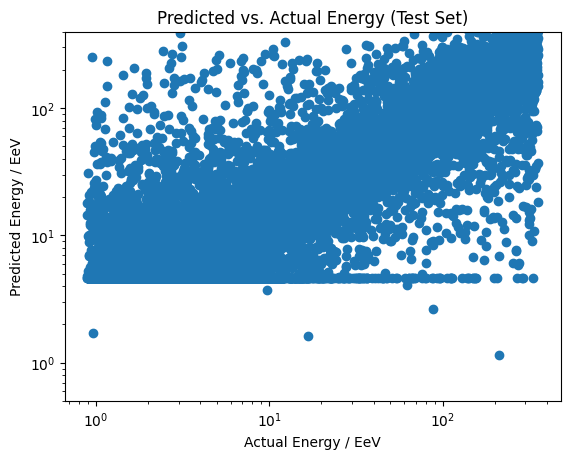

In [27]:
# Evaluation function
def evaluate_cosmic_ray_model(model, X_test, y_test, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(X_test)
        loss = criterion(outputs, y_test)
    print(f'Test Loss: {loss.item():.4f}')
    return outputs


test_outputs = evaluate_cosmic_ray_model(model, X_test, y_test, criterion)

# Optional: plot the predicted vs. actual energy values

plt.scatter(y_test.cpu(), test_outputs.cpu())
plt.xlabel('Actual Energy / EeV')
plt.xscale('log')
plt.yscale('log')
plt.ylim(5e-1,4e2)
plt.ylabel('Predicted Energy / EeV')
plt.title('Predicted vs. Actual Energy (Test Set)')
plt.show()

#### Take-home for application on real data

Today we only trained a network on simulated data and will not apply such a network to real, unknown data. Before a model can be applied to real-life data, we need to do certain robustness checks to account for deviations of the real-life physics to our simulation (what we know and can predict). 

* If the training on simulated data works sufficiently well, we need to ensure the model is applicable to data that can deviate within a certain range from the simulation. This is often tested by simulating a quantity from different models or artificial variation within certain value ranges. The model should perform sufficiently well on these simulated data sets as well.

* The data-simulation-agreement needs to be sufficiently well for the estimator quantities. Deviations in the feature can lead to wrong predictions.

* Proper handling of training, test and validation set. Hyperparameter of a model are optimized using a second set that tests the performs. At the very last step, the optimized model is evaluated on a third set.
